<a href="https://colab.research.google.com/github/eueu29/AIFFEL_quest/blob/main/Exploration_quest/quest02/news_summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 추상적 요약

## 기본 embedding, LSTM

### 데이터 증강 text attack

In [ ]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


In [ ]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

### 데이터전처리

In [ ]:
# import urllib.request
# urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [ ]:
data.loc[0].text

In [ ]:
data.loc[0].headlines

In [ ]:
data.head()

In [ ]:
data.info()

#### 중복, null값 제거

In [ ]:
# 중복값 제거
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

In [ ]:
# inplace=True 를 설정하면 DataFrame 내부를 직접적으로 바꿈
data.drop_duplicates(subset = ['text'], inplace=True)
data.drop_duplicates(subset = ['headlines'], inplace=True)
print('전체 샘플수 :', (len(data)))
# 중복값 제거
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

In [ ]:
# null값 있는지 확인
print(data.isnull().sum())

#### 텍스트 정규화와 불용어 제거

In [ ]:
# 정규화 사전구성
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [ ]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

In [ ]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [ ]:
clean_text = []

for sentence in data['text']:
    cleaned = preprocess_sentence(sentence)
    clean_text.append(cleaned)

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

In [ ]:
clean_headlines = []

for sentence in data['headlines']:
    cleaned = preprocess_sentence(sentence,False)
    clean_headlines.append(cleaned)

print("Summary 전처리 후 결과: ", clean_headlines[:5])

In [ ]:
data['text'] = clean_text
data['headlines'] = clean_headlines

In [ ]:
# null값 생겼는지 확인
data.isnull().sum()

In [ ]:
data.to_csv('news_data.csv', index=False)

### 데이터 전처리, 불용어 제거 후

In [ ]:
data = pd.read_csv('news_data.csv')

In [ ]:
data.info()

In [ ]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headline')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of Headlines')
plt.ylabel('number of Headlines')
plt.show()

In [ ]:
# data['text_len'] = text_len
# data['text_head'] = headlines_len

In [ ]:
# data_text = data.sort_values(by='text_len')

In [ ]:
# data_text

In [ ]:
# data_head = data.sort_values(by='text_head')

In [ ]:
# data_head

index 52 : 제목이 추가돼버려서 삭제  

In [ ]:
data = data.drop(52)

In [ ]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headline')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of Headlines')
plt.ylabel('number of Headlines')
plt.show()

#### 시작, 종료 토큰 추가하기

In [ ]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

In [ ]:
data.to_csv('data_input.csv',index=False)

### 최종 데이터

In [ ]:
data = pd.read_csv('data_input.csv')

In [ ]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [ ]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[78891 68140 45937 ... 79517 28718  8226]


#### train, test data 분리하기

In [ ]:
# shuffle된 indices 시퀀스를 이용해 잘 섞인 샘플 만들기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
# 텍스트 데이터 갯수 정하기
n_of_val = int(len(encoder_input)*0.2)

# 데이터 나누기
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

#### 단어집합 만들고 정수인코딩 하기

In [ ]:
# Keras의 토크나이저를 사용해서 입력된 훈련 데이터로부터 단어 집합을 만들기
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 리스트를 인자로 받고 숫자정보를 매핑

In [ ]:
src_vocab_size = len(src_tokenizer.word_index) + 1 # 패딩을 고려하여 +1
print('단어 집합 :',src_vocab_size)

단어 집합 : 69531


In [ ]:
# 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69530
등장 빈도가 6번 이하인 희귀 단어의 수: 47383
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22147
단어 집합에서 희귀 단어의 비율: 68.14756220336545
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.489958519395725


20000으로 단어집합의 크기를 제한

In [ ]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[5861, 3593, 202, 7572, 293, 5916, 6739, 364, 1085, 293, 137, 2516, 4339, 3416, 2516, 6989, 11257, 2516, 146, 160, 708, 4369, 909, 5916, 5861, 542, 1010, 16701, 1854, 7, 378], [5, 16, 125, 44, 72, 66, 427, 1586, 10702, 5641, 5917, 3795, 3263, 1081, 1002, 771, 5, 84, 2799, 424, 12564, 244, 63, 376, 861, 158, 260, 575, 469, 44, 1655, 469, 2799, 2025, 2517, 5114, 10056], [1446, 109, 360, 94, 9, 1362, 78, 79, 1521, 174, 95, 391, 1446, 9, 6, 184, 8822, 1487, 110, 265, 1521, 241, 22, 2728, 15372, 1446, 9, 2477, 500, 3019, 207]]


In [ ]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [ ]:
tar_vocab_size = len(tar_tokenizer.word_index) + 1 # 패딩을 고려하여 +1
print('단어 집합 :',tar_vocab_size)

단어 집합 : 30003


In [ ]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30002
등장 빈도가 5번 이하인 희귀 단어의 수: 19572
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10430
단어 집합에서 희귀 단어의 비율: 65.2356509566029
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.6227111024889815


단어집합 10000개로 제한

In [ ]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 50, 314, 3489, 19, 50, 4, 189, 2683, 4541, 3490, 3238], [1, 29, 185, 74, 6, 2230, 13, 331, 1673], [1, 1349, 61, 1542, 744, 104, 65, 393, 153, 3, 201], [1, 154, 149, 1350, 1951, 15, 174, 157, 6, 30, 1018], [1, 63, 26, 2106, 146, 499, 153, 5, 1112, 5634]]
target
decoder  [[50, 314, 3489, 19, 50, 4, 189, 2683, 4541, 3490, 3238, 2], [29, 185, 74, 6, 2230, 13, 331, 1673, 2], [1349, 61, 1542, 744, 104, 65, 393, 153, 3, 201, 2], [154, 149, 1350, 1951, 15, 174, 157, 6, 30, 1018, 2], [63, 26, 2106, 146, 499, 153, 5, 1112, 5634, 2]]


In [ ]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78609
훈련 레이블의 개수 : 78609
테스트 데이터의 개수 : 19652
테스트 레이블의 개수 : 19652


#### 패딩하기

In [ ]:
text_max_len = 60
head_max_len = 16

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=head_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=head_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=head_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=head_max_len, padding='post')

### 모델 설계하기

#### LSTM

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [ ]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

#### Attention layer 추가

In [ ]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

#### 모델 훈련하기

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 47s 129ms/step - loss: 4.2846 - val_loss: 3.9448
Epoch 2/50
308/308 [==============================] - 40s 130ms/step - loss: 3.7901 - val_loss: 3.6556
Epoch 3/50
308/308 [==============================] - 41s 135ms/step - loss: 3.5482 - val_loss: 3.5067
Epoch 4/50
308/308 [==============================] - 43s 139ms/step - loss: 3.3623 - val_loss: 3.3497
Epoch 5/50
308/308 [==============================] - 42s 137ms/step - loss: 3.2036 - val_loss: 3.2513
Epoch 6/50
308/308 [==============================] - 42s 138ms/step - loss: 3.0725 - val_loss: 3.1481
Epoch 7/50
308/308 [==============================] - 42s 138ms/step - loss: 2.9627 - val_loss: 3.0926
Epoch 8/50
308/308 [==============================] - 42s 137ms/step - loss: 2.8701 - val_loss: 3.0219
Epoch 9/50
308/308 [==============================] - 42s 137ms/step - loss: 2.7870 - val_loss: 2.9710
Epoch 10/50
308/308 [==============================] - 42s 138ms/step - l

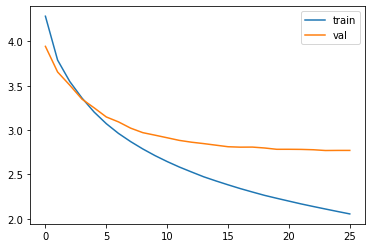

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

#### 인퍼런스 모델 구현하기

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (head_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

#### 모델 테스트하기

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0 and i!=tar_word_to_index['sostoken'] and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i]+' '
    return temp.strip()

In [ ]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : british broke back getting crushed nearly foot wave surfing beach portugal andrew cotton thrown board slammed back first water high speed engulfed briefly monster wave split second said year old 
실제 요약 : british breaks back after being crushed by ft wave
예측 요약 :  man trapped in thailand to foot water from water


원문 : pakistan public prosecutor allegedly told christians accused murder guarantee acquittal christianity embrace islam christians charged killing two muslims suspected planning suicide blasts two churches least people killed blasts 
실제 요약 : christians offered acquittal on conversion to islam in pak
예측 요약 :  pak man sentenced to jail for murder of sikh in jail


원문 : restaurant new york every menu item features app restaurant serves fries five different types well featuring interestingly seater restaurant even features themed decor including special 
실제 요약 : every menu item features at new york restaurant
예측 요약 :  japanese eatery lets users eatery to make food food


원문 :

## Glove embedding + LSTM

In [ ]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

In [ ]:
data = pd.read_csv('data_input.csv')

In [ ]:
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [ ]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [ ]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

In [ ]:
# shuffle된 indices 시퀀스를 이용해 잘 섞인 샘플 만들기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
# 텍스트 데이터 갯수 정하기
n_of_val = int(len(encoder_input)*0.2)

# 데이터 나누기
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [ ]:
# Keras의 토크나이저를 사용해서 입력된 훈련 데이터로부터 단어 집합을 만들기
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 리스트를 인자로 받고 숫자정보를 매핑

In [ ]:
# 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69683
등장 빈도가 6번 이하인 희귀 단어의 수: 47572
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22111
단어 집합에서 희귀 단어의 비율: 68.26916177546892
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.504797170973492


In [ ]:
src_vocab = 20000
src_tokenizer2 = Tokenizer(num_words=src_vocab)
src_tokenizer2.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [ ]:
src_vocab_size = len(src_tokenizer2.word_index) + 1 # 패딩을 고려하여 +1
print('단어 집합 :',src_vocab_size)

단어 집합 : 69684


In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [ ]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [ ]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29925
등장 빈도가 5번 이하인 희귀 단어의 수: 19481
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10444
단어 집합에서 희귀 단어의 비율: 65.09941520467837
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.601962545354366


In [ ]:
tar_vocab = 10000
tar_tokenizer2 = Tokenizer(num_words=tar_vocab)
tar_tokenizer2.fit_on_texts(decoder_input_train)
tar_tokenizer2.fit_on_texts(decoder_target_train)

In [ ]:
tar_vocab_size = len(tar_tokenizer2.word_index) + 1 # 패딩을 고려하여 +1
print('단어 집합 :',tar_vocab_size)

단어 집합 : 29927


In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [ ]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78609
훈련 레이블의 개수 : 78609
테스트 데이터의 개수 : 19652
테스트 레이블의 개수 : 19652


In [ ]:
text_max_len = 60
head_max_len = 16

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=head_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=head_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=head_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=head_max_len, padding='post')

In [ ]:
from urllib.request import urlretrieve, urlopen
import gzip
import zipfile

In [ ]:
embedding_dict = dict()

f = open('glove.6B.100d.txt', encoding="utf8")

for line in f:
    word_vector = line.split()
    word = word_vector[0]

    # 100개의 값을 가지는 array로 변환
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
    embedding_dict[word] = word_vector_arr
f.close()

In [ ]:
embedding_matrix_src = np.zeros((src_vocab_size, 100))

for word, index in src_tokenizer.word_index.items():
    # 단어와 맵핑되는 사전 훈련된 임베딩 벡터값
    vector_value = embedding_dict.get(word)
    if vector_value is not None:
        embedding_matrix_src[index] = vector_value

In [ ]:
embedding_matrix_tar = np.zeros((tar_vocab_size, 100))

for word, index in tar_tokenizer.word_index.items():
    # 단어와 맵핑되는 사전 훈련된 임베딩 벡터값
    vector_value = embedding_dict.get(word)
    if vector_value is not None:
        embedding_matrix_tar[index] = vector_value

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
output_dim = 100
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab_size, output_dim, weights=[embedding_matrix_src], input_length=text_max_len, trainable=False)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [ ]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb = Embedding(tar_vocab_size, output_dim, weights=[embedding_matrix_tar], input_length=head_max_len, trainable=False)(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [ ]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab_size, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

In [ ]:
import numpy as np

# NaN이나 Inf가 있는지 확인
print(np.isnan(encoder_input_train).any(), np.isnan(decoder_input_train).any())
print(np.isinf(encoder_input_train).any(), np.isinf(decoder_input_train).any())

In [ ]:
print(np.isnan(embedding_matrix_src).any())  # True가 출력되면 NaN이 존재
print(np.isnan(embedding_matrix_tar).any())  # True가 출력되면 NaN이 존재

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 79s 234ms/step - loss: 4.6892 - val_loss: 4.2458
Epoch 2/50
308/308 [==============================] - 73s 237ms/step - loss: 4.1178 - val_loss: 3.9028
Epoch 3/50
308/308 [==============================] - 73s 237ms/step - loss: 3.8524 - val_loss: 3.6854
Epoch 4/50
308/308 [==============================] - 73s 237ms/step - loss: 3.6797 - val_loss: 3.5844
Epoch 5/50
308/308 [==============================] - 73s 237ms/step - loss: 3.5498 - val_loss: 3.4897
Epoch 6/50
308/308 [==============================] - 73s 237ms/step - loss: 3.4438 - val_loss: 3.4173
Epoch 7/50
308/308 [==============================] - 73s 237ms/step - loss: 3.3568 - val_loss: 3.3659
Epoch 8/50
308/308 [==============================] - 73s 237ms/step - loss: 3.2830 - val_loss: 3.3099
Epoch 9/50
308/308 [==============================] - 73s 237ms/step - loss: 3.2235 - val_loss: 3.2922
Epoch 10/50
308/308 [==============================] - 73s 237ms/step - l

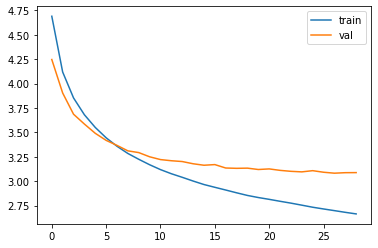

In [ ]:
 plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

## word2vec + transformer


### 1. 데이터 준비 및 전처리

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import nltk
# nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


In [ ]:
df = pd.read_csv("/content/sample_data/news_data.csv")
# df.drop('Unnamed: 0', axis=1, inplace=True)
df.rename(columns = {'headlines' : 'summary'}, inplace=True)
df

,summary,text
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...
...,...,...
16776,bsf jawan arrested for spying police say he wa...,bsf jawan alleged honey trapped pakistan isi a...
16777,kolkata bagree market fire completely controll...,senior fire department official said fire erup...
16778,sc summons delhi bjp chief for breaking lock o...,supreme court issued contempt notice delhi bjp...
16779,pakistan pm visits saudi arabia for bailout ta...,pakistan prime minister imran khan visiting sa...


In [ ]:
# 훈련 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['summary'], test_size=0.2, random_state=42)

In [ ]:
# 텍스트를 시퀀스로 변환
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
y_train_seq = tokenizer.texts_to_sequences(y_train)
y_test_seq = tokenizer.texts_to_sequences(y_test)

In [ ]:
# 패딩 처리

max_seq_length = 100  # 최대 시퀀스 길이
X_train_padded = pad_sequences(X_train_seq, maxlen=max_seq_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_seq_length, padding='post')
y_train_padded = pad_sequences(y_train_seq, maxlen=max_seq_length, padding='post')
y_test_padded = pad_sequences(y_test_seq, maxlen=max_seq_length, padding='post')

### 2. Word2Vec 임베딩

In [ ]:
import gensim
import numpy as np
from tensorflow.keras.layers import Embedding

In [ ]:
# Word2Vec 모델 학습
sentences = [text.split() for text in X_train]
word2vec_model = gensim.models.Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
# 임베딩 매트릭스 생성
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

In [ ]:
# 임베딩 레이어 생성
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_seq_length, trainable=False)

### 3. 트랜스포머 모델 설계

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D, TimeDistributed
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Add

In [ ]:
# 트랜스포머 블록 정의
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0):
    attention_output = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + inputs)

    ff_output = Dense(ff_dim, activation="relu")(attention_output)
    ff_output = Dropout(dropout)(ff_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Add()([ff_output, attention_output])

    return LayerNormalization(epsilon=1e-6)(ff_output)

In [ ]:
# 모델 정의
inputs = Input(shape=(max_seq_length,))
x = embedding_layer(inputs)
x = transformer_block(x, head_size=128, num_heads=4, ff_dim=128, dropout=0.1)
x = Dropout(0.1)(x)
outputs = TimeDistributed(Dense(vocab_size, activation="softmax"))(x)  # 각 시퀀스 타임스텝마다 출력

model = Model(inputs, outputs)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 100, 100)       │      3,141,900 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_2    │ (None, 100, 100)       │        206,436 │ embedding_1[0][0],     │
│ (MultiHeadAttention)      │                        │                │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 100, 100)       │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 100, 100)       │              0 │ dropout_9[0][0],       │
│                           │                        │                │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_4     │ (None, 100, 100)       │            200 │ add_4[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 100, 128)       │         12,928 │ layer_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 100, 128)       │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 100, 100)       │         12,900 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 100, 100)       │              0 │ dense_6[0][0],         │
│                           │                        │                │ layer_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_5     │ (None, 100, 100)       │            200 │ add_5[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 100, 100)       │              0 │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_1        │ (None, 100, 31419)     │      3,173,319 │ dropout_11[0][0]       │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,547,883 (24.98 MB)

 Trainable params: 3,405,983 (12.99 MB)

 Non-trainable params: 3,141,900 (11.99 MB)

3# 4. 학습

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train_padded, y_train_padded, validation_split=0.2, epochs=50, batch_size=128, callbacks=[early_stopping])

Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.8431 - loss: 6.5946 - val_accuracy: 0.9273 - val_loss: 0.9005
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 32s 385ms/step - accuracy: 0.9275 - loss: 0.8881 - val_accuracy: 0.9273 - val_loss: 0.8774
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 32s 378ms/step - accuracy: 0.9277 - loss: 0.8513 - val_accuracy: 0.9273 - val_loss: 0.8118
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 32s 379ms/step - accuracy: 0.9275 - loss: 0.8033 - val_accuracy: 0.9273 - val_loss: 0.7976
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 32s 381ms/step - accuracy: 0.9274 - loss: 0.7875 - val_accuracy: 0.9273 - val_loss: 0.7823
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 32s 379ms/step - accuracy: 0.9276 - loss: 0.7677 - val_accuracy: 0.9273 - val_loss: 0.7695
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 32s 380ms/step - accuracy: 0.9275 - loss: 0.7521 - val_accuracy: 0.9273 - val_loss: 0.7612
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 32s 381ms/step - accuracy: 0.9278 - loss: 0.7369 - val_accura

### 5. 학습 결과

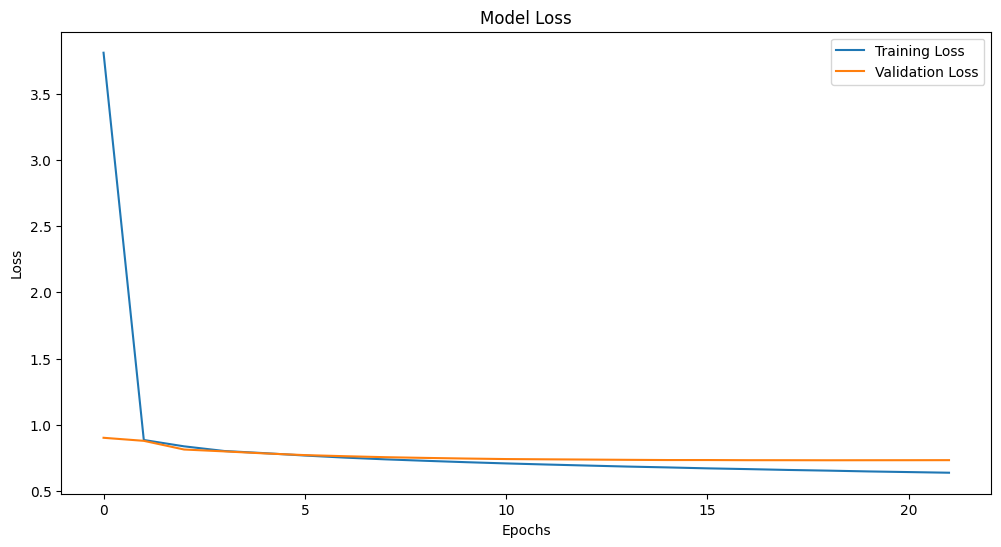

In [ ]:
import matplotlib.pyplot as plt

# 학습 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### 6. 예측 테스트

In [ ]:
# 모델 평가
loss, accuracy = model.evaluate(X_test_padded, y_test_padded)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

105/105 ━━━━━━━━━━━━━━━━━━━━ 32s 158ms/step - accuracy: 0.9287 - loss: 0.7106
Test Loss: 0.7079
Test Accuracy: 0.9290


In [ ]:
!pip install summa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54389 sha256=ccdf132d3c7bd21e615bed31465369a202ab8394012f8a0033752c1c23101f9d
  Stored in directory: /root/.cache/pip/wheels/4a/ca/c5/4958614cfba88ed6ceb7cb5a849f9f89f9ac49971616bc919f
Successfully built summa


In [ ]:
from summa import summarizer

def summarize_text(text, ratio=0.5):
    if isinstance(text, list):
        text = ' '.join(text)
    return summarizer.summarize(text, ratio=ratio)

batch_size = 32
predictions = []
for text in X_test_padded:  # Iterate over each text in the dataset
    summary = summarize_text(tokenizer.sequences_to_texts([text])[0], 0.0005)  # Convert tokenized sequence to text
    # Tokenize and pad the summary, then predict
    summary_sequence = tokenizer.texts_to_sequences([summary])
    summary_padded = pad_sequences(summary_sequence, maxlen=X_test_padded.shape[1], padding='post')
    prediction = model.predict(summary_padded)
    predictions.append(prediction)

# 실제 레이블과 예측된 레이블 비교
for i in range(5):  # 상위 5개 샘플만 출력
    # 예측된 시퀀스 가져오기
    predicted_sequence = predictions[i].argmax(axis=-1)

    # 실제 레이블 시퀀스 가져오기
    actual_sequence = y_test_padded[i]

    # 패딩 제거
    predicted_sequence = [token for token in predicted_sequence if token != 0]
    actual_sequence = [token for token in actual_sequence if token != 0]

    # 텍스트로 변환
    predicted_text = tokenizer.sequences_to_texts([predicted_sequence])[0]
    actual_text = tokenizer.sequences_to_texts([actual_sequence])[0]

    # 출력
    print(f"Sample {i+1}")
    print(f"Predicted: {predicted_text}")
    print(f"Actual: {actual_text}")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [ ]:
# 데이터 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)

    return tokens

In [ ]:
# 샘플 예측
sample_text = "Example news content to summarize"

sample_seq = tokenizer.texts_to_sequences([preprocess_sentence(sample_text)])

max_seq_length = 100  # 최대 시퀀스 길이
sample_padded = pad_sequences(sample_seq, maxlen=max_seq_length, padding='post')

predicted_summary = model.predict(sample_padded)
predicted_summary = tokenizer.sequences_to_texts(predicted_summary.argmax(axis=-1))
print("Predicted Summary:", " ".join(predicted_summary))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Summary: 


# 추출적 요약

In [ ]:
# cloud shell에서 다음을 시행
# $ pip list | grep summa

In [54]:
import requests
from summa.summarizer import summarize

In [55]:
# 매트릭스 시놉시스를 다운로드
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

## summarize 사용하기

Summa의 summarize()의 인자로 사용되는 값들에 대해서 알아볼게요.

>text (str) : 요약할 테스트.  
ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값  
words (int or None, optional) – 출력에 포함할 단어 수.  
만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.  
split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환  
<br>  

Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행해요. 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있어요

In [56]:
# 원문의 0.005%만을 출력하도록 설정
print(summarize(text, ratio=0.005))

# 만약 리스트로 출력 결과를 받고 싶다면 split 인자의 값을 True
print(summarize(text, ratio=0.005, split=True))

# 단어의 수로 요약문의 크기를 조절할 수도 있어요. 단어를 50개만 선택
print(summarize(text, words=50))

Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


# 회고

이유진 : 임베딩 층을 바꿔보는것도 쉽지 않았다. 임베딩 층을 새로 적용하니 모델 결과 예측하는 것도 바꾸어야 하는데 쉽지 않아 아쉬웠다. 하지만 토크나이징, 임베딩, LTSM, transformer 모델에 대해 조금은 더 이해할 수 있었던것 같다. 시간이 없어 플러터를 구현하지 못한부분도 너무 아쉽다.  
회고는 함께하지 못했지만 선웅님께서 word2vec과 transformer 모델을 잘 구현해주셨습니다. 학습은 아주 안정적이고 만족스러운 점수가 나왔지만, 결과를 예측하는 부분에서 에러가 나서 완성하지 못한것도 아쉽네요...